# Feedbacks CERES via SW fluxes

(1) Reconstruit les données avec les PCs et EOFs des flux SW. 

(2) Multi Linéaire Régression des PCs sur les feedbacks pour trouver les coefficients Beta. 

(3) Retrouver les PCs des observations CERES. 

(4) Prédire les feedbacks des observations.

# Importe modules

In [120]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

# Functions definition

In [121]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda
from Fonctions import get_3D_budget_xarr
from Fonctions import get_3D_xarr
from Fonctions import get_3D_SW_xarr
from Fonctions import get_3D_LW_xarr

# EOF, SW_mean and PCs

In [122]:
SW_mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_SW_mean.npy').to_xarray().to_array()
SW_mean = SW_mean[0,:,:].rename({'variable':'mode'})
SW_mean

<xarray.DataArray (lat: 128, lon: 256)>
array([[46.199223, 46.199223, 46.199223, ..., 46.199223, 46.199223,
        46.199223],
       [52.107582, 52.107582, 52.107582, ..., 52.107582, 52.107582,
        52.107582],
       [49.17443 , 49.17443 , 49.17443 , ..., 49.05776 , 49.17443 ,
        49.17443 ],
       ...,
       [57.367985, 57.367985, 57.367985, ..., 57.97106 , 57.367985,
        57.367985],
       [56.62396 , 56.62396 , 56.62396 , ..., 56.62396 , 56.62396 ,
        56.62396 ],
       [55.8613  , 55.8613  , 55.8613  , ..., 55.8613  , 55.8613  ,
        55.8613  ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'SWmean'

In [123]:
SW_anom =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_SW_anom.npy').to_xarray().to_array()
SW_anom = SW_anom[0,:,:].rename({'variable':'mode'})
SW_anom

<xarray.DataArray (time: 104, lat: 128, lon: 256)>
array([[[-1.1409416 , -1.1409416 , -1.1409416 , ..., -1.1409416 ,
         -1.1409416 , -1.1409416 ],
        [-0.33542633, -0.33542633, -0.33542633, ..., -0.33542633,
         -0.33542633, -0.33542633],
        [-1.6586761 , -1.6586761 , -1.6586761 , ..., -1.4652138 ,
         -1.6586761 , -1.6586761 ],
        ...,
        [ 0.71084976,  0.71084976,  0.71084976, ...,  0.9044342 ,
          0.71084976,  0.71084976],
        [ 1.1314201 ,  1.1314201 ,  1.1314201 , ...,  1.1314201 ,
          1.1314201 ,  1.1314201 ],
        [ 1.2839546 ,  1.2839546 ,  1.2839546 , ...,  1.2839546 ,
          1.2839546 ,  1.2839546 ]],

       [[-0.77750015, -0.77750015, -0.77750015, ..., -0.77750015,
         -0.77750015, -0.77750015],
        [-0.79998016, -0.79998016, -0.79998016, ..., -0.79998016,
         -0.79998016, -0.79998016],
        [-1.791275  , -1.791275  , -1.791275  , ..., -1.3708153 ,
         -1.791275  , -1.791275  ],
        ...,
        [-1.5574074 , -1.5574074 , -1.5574074 , ..., -1.5475311 ,
         -1.5574074 , -1.5574074 ],
        [-0.9004402 , -0.9004402 , -0.9004402 , ..., -0.9004402 ,
         -0.9004402 , -0.9004402 ],
        [ 1.3266792 ,  1.3266792 ,  1.3266792 , ...,  1.3266792 ,
          1.3266792 ,  1.3266792 ]],

       [[ 1.2937126 ,  1.2937126 ,  1.2937126 , ...,  1.2937126 ,
          1.2937126 ,  1.2937126 ],
        [-0.15394592, -0.15394592, -0.15394592, ..., -0.15394592,
         -0.15394592, -0.15394592],
        [ 1.7314453 ,  1.7314453 ,  1.7314453 , ...,  0.8574028 ,
          1.7314453 ,  1.7314453 ],
        ...,
        [-0.92010117, -0.92010117, -0.92010117, ..., -0.8666153 ,
         -0.92010117, -0.92010117],
        [-1.2010765 , -1.2010765 , -1.2010765 , ..., -1.2010765 ,
         -1.2010765 , -1.2010765 ],
        [-1.323925  , -1.323925  , -1.323925  , ..., -1.323925  ,
         -1.323925  , -1.323925  ]],

       ...,

       [[-0.64216995, -0.64216995, -0.64216995, ..., -0.64216995,
         -0.64216995, -0.64216995],
        [-1.1584396 , -1.1584396 , -1.1584396 , ..., -1.1584396 ,
         -1.1584396 , -1.1584396 ],
        [-0.8942337 , -0.8942337 , -0.8942337 , ..., -0.9702034 ,
         -0.8942337 , -0.8942337 ],
        ...,
        [ 0.3174858 ,  0.3174858 ,  0.3174858 , ..., -0.02619171,
          0.3174858 ,  0.3174858 ],
        [-0.05865097, -0.05865097, -0.05865097, ..., -0.05865097,
         -0.05865097, -0.05865097],
        [-0.607357  , -0.607357  , -0.607357  , ..., -0.607357  ,
         -0.607357  , -0.607357  ]],

       [[ 0.61680984,  0.61680984,  0.61680984, ...,  0.61680984,
          0.61680984,  0.61680984],
        [ 0.6228256 ,  0.6228256 ,  0.6228256 , ...,  0.6228256 ,
          0.6228256 ,  0.6228256 ],
        [-0.37311554, -0.37311554, -0.37311554, ...,  0.560421  ,
         -0.37311554, -0.37311554],
        ...,
        [-0.02377701, -0.02377701, -0.02377701, ..., -0.4250641 ,
         -0.02377701, -0.02377701],
        [-0.44558334, -0.44558334, -0.44558334, ..., -0.44558334,
         -0.44558334, -0.44558334],
        [-0.877758  , -0.877758  , -0.877758  , ..., -0.877758  ,
         -0.877758  , -0.877758  ]],

       [[-0.70367813, -0.70367813, -0.70367813, ..., -0.70367813,
         -0.70367813, -0.70367813],
        [-0.48632812, -0.48632812, -0.48632812, ..., -0.48632812,
         -0.48632812, -0.48632812],
        [ 0.7792206 ,  0.7792206 ,  0.7792206 , ...,  0.44358444,
          0.7792206 ,  0.7792206 ],
        ...,
        [ 0.57520676,  0.57520676,  0.57520676, ...,  0.22793579,
          0.57520676,  0.57520676],
        [ 0.43892288,  0.43892288,  0.43892288, ...,  0.43892288,
          0.43892288,  0.43892288],
        [ 0.17402267,  0.17402267,  0.17402267, ...,  0.17402267,
          0.17402267,  0.17402267]]], dtype=float32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 95 96 97 98 99 100 101 102 103
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 

In [124]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_SW.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_SW.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_SW.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_SW.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_SW.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

eofs = [eof1,eof2,eof3,eof4,eof5]

In [125]:
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')
#eofs_combined

In [126]:
pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_SW.npy')
pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_SW.npy')
pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_SW.npy')
pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_SW.npy')
pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_SW.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)
#PC_df

PC_df

,pc1,pc2,pc3,pc4,pc5
0,-2.047370,-1.880304,0.695610,0.412089,1.125757
1,-0.089449,0.496158,0.467263,1.178991,-0.047902
2,-0.116755,-1.046896,0.690340,0.520982,-0.465930
3,-0.185584,-0.481452,-1.690353,1.516815,-1.070043
4,-0.715558,-2.260906,0.754414,0.866320,0.442949
...,...,...,...,...,...
97,-0.171289,1.157343,1.041486,0.640221,0.379474
98,1.242522,0.038309,0.262175,-0.554142,-1.030054
99,0.691113,0.455628,0.654231,0.037726,0.280656
100,-0.174369,0.459418,1.376890,0.565844,1.431882


In [127]:
pc1_official = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF1pc_SW.npy')
pc2_official = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF2pc_SW.npy')
pc3_official = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF3pc_SW.npy')
pc4_official = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF4pc_SW.npy')
pc5_official = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF5pc_SW.npy')

pc1_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_SW.npy')
pc2_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_SW.npy')
pc3_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_SW.npy')
pc4_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_SW.npy')
pc5_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_SW.npy')

In [128]:
PCs = [0]*102
for i in range(0,102,1):
    tmp = PC_df.iloc[i].values
    PCs[i] = tmp

PCs

[array([-2.0473702 , -1.880304  ,  0.6956099 ,  0.41208935,  1.1257575 ],
       dtype=float32),
 array([-0.08944946,  0.49615845,  0.4672631 ,  1.178991  , -0.04790198],
       dtype=float32),
 array([-0.1167547 , -1.0468956 ,  0.69033986,  0.5209821 , -0.4659299 ],
       dtype=float32),
 array([-0.18558356, -0.48145172, -1.6903527 ,  1.5168148 , -1.0700426 ],
       dtype=float32),
 array([-0.7155578 , -2.2609057 ,  0.75441384,  0.86632043,  0.44294903],
       dtype=float32),
 array([ 0.20396589, -0.46247607,  1.2026341 ,  0.05917398, -0.0152133 ],
       dtype=float32),
 array([ 0.19003962, -0.7868893 , -0.88256663,  0.32877818,  1.6998976 ],
       dtype=float32),
 array([ 1.3131622 ,  0.14463289, -0.3204229 , -0.1717642 , -0.2851    ],
       dtype=float32),
 array([ 1.2999152 , -0.45342883, -0.94727796, -0.43290284,  0.67895526],
       dtype=float32),
 array([ 0.4211615 ,  1.4570041 , -0.91464233,  0.7379039 ,  0.37559077],
       dtype=float32),
 array([ 0.9311749 , -0.053579

# Trouver U_obs : Reconstruciton des données

X_ens = U_ens(pc) * v_ens(eof) 

Compute anomaly : X_obs = X_obs - SW_mean_ens 

X_obs = U_obs * v_ens 

U_obs = X_obs * inv(v_ens)

## Get the CERES datatset

In [129]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['month']=pd.DatetimeIndex(df1['time']).month # time in years
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    
    return df_mean

In [130]:
path_observation = '/data/home/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'
    
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

In [131]:
df_obs['SW'] =  df_obs['toa_net_all_mon'] + df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    SW               (lat, lon) float32 51.417324 51.417324 ... 67.64632

## Compute Anomaly

In [132]:
SW_mean

<xarray.DataArray (lat: 128, lon: 256)>
array([[46.199223, 46.199223, 46.199223, ..., 46.199223, 46.199223,
        46.199223],
       [52.107582, 52.107582, 52.107582, ..., 52.107582, 52.107582,
        52.107582],
       [49.17443 , 49.17443 , 49.17443 , ..., 49.05776 , 49.17443 ,
        49.17443 ],
       ...,
       [57.367985, 57.367985, 57.367985, ..., 57.97106 , 57.367985,
        57.367985],
       [56.62396 , 56.62396 , 56.62396 , ..., 56.62396 , 56.62396 ,
        56.62396 ],
       [55.8613  , 55.8613  , 55.8613  , ..., 55.8613  , 55.8613  ,
        55.8613  ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'SWmean'

In [133]:
X_obs = obs['SW'] - SW_mean
X_obs

<xarray.DataArray (lat: 128, lon: 256)>
array([[ 5.2181015,  5.2181015,  5.2181015, ...,  5.237549 ,  5.2181015,
         5.2181015],
       [ 1.2252731,  1.2252731,  1.2252731, ...,  1.2478867,  1.2252731,
         1.2252731],
       [ 4.9700813,  4.9700813,  4.9700813, ...,  5.088505 ,  4.9700813,
         4.9700813],
       ...,
       [11.630268 , 11.630268 , 11.630268 , ..., 11.095985 , 11.630268 ,
        11.630268 ],
       [11.547985 , 11.547985 , 11.547985 , ..., 11.503666 , 11.547985 ,
        11.547985 ],
       [11.785015 , 11.785015 , 11.785015 , ..., 11.783306 , 11.785015 ,
        11.785015 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'SWmean'

## Trouver U_obs

In [134]:
PCs = PC_df.to_xarray().to_array()
PCs

<xarray.DataArray (variable: 5, index: 102)>
array([[-2.04737020e+00, -8.94494578e-02, -1.16754696e-01,
        -1.85583562e-01, -7.15557814e-01,  2.03965887e-01,
         1.90039620e-01,  1.31316221e+00,  1.29991519e+00,
         4.21161503e-01,  9.31174874e-01, -6.28354669e-01,
        -5.79207063e-01, -4.30240810e-01,  1.51863009e-01,
        -5.90365052e-01,  2.00472429e-01,  1.73941922e+00,
         4.29479748e-01, -5.68679810e-01,  5.20925879e-01,
        -2.29294941e-01,  3.42368454e-01,  1.88650537e+00,
        -2.28423119e+00,  6.44406974e-01, -9.99041080e-01,
         1.79709971e+00, -5.16962469e-01, -4.11020778e-02,
         8.55706036e-02,  2.21120819e-01,  2.27223590e-01,
         4.05216634e-01, -1.85999840e-01,  9.22838390e-01,
        -5.76828718e-01,  7.73146272e-01,  1.38811827e+00,
        -1.93730521e+00, -6.24028981e-01, -2.64279890e+00,
        -1.17824352e+00, -1.11090934e+00, -1.96624005e+00,
         9.68336284e-01, -5.38397506e-02, -3.98658603e-01,
        -2.70110679e+00,  1.66269168e-01,  5.72049797e-01,
         1.26800859e+00,  1.08044535e-01, -5.52864969e-01,
        -5.90850949e-01, -1.30483997e+00, -6.41446948e-01,
        -1.77884591e+00, -1.66810483e-01,  1.09450722e+00,
         1.42208338e+00,  1.84099233e+00, -7.82108426e-01,
         8.63288164e-01, -4.69454825e-02, -1.96288809e-01,
         1.26895452e+00, -9.06502962e-01,  9.05040920e-01,
        -2.50167489e-01,  6.41884387e-01,  1.23080277e+00,
        -4.68572706e-01,  8.89474601e-02,  1.07761848e+00,
         2.06496373e-01,  1.14576828e+00,  1.47584617e-01,
        -2.51188731e+00, -1.65411443e-01, -1.91179538e+00,
         1.67286962e-01,  7.83049583e-01, -7.37686008e-02,
        -7.24271834e-01,  9.34867859e-01, -5.26541114e-01,
         6.52448952e-01, -2.34614462e-01, -4.03086156e-01,
         6.22552037e-02,  8.28076065e-01, -6.14756823e-01,
         1.76152617e-01, -5.73581815e-01, -2.78669268e-01,
         4.31847274e-01, -1.71288818e-01,  1.24252224e+00,
         6.91113234e-01, -1.74369469e-01,  1.98342621e+00],
       [-1.88030398e+00,  4.96158451e-01, -1.04689562e+00,
        -4.81451720e-01, -2.26090574e+00, -4.62476075e-01,
        -7.86889315e-01,  1.44632891e-01, -4.53428835e-01,
         1.45700407e+00, -5.35793006e-02, -1.56922504e-01,
         1.50936043e+00,  4.78317648e-01, -1.03987921e-02,
         7.64245987e-02, -1.00206232e+00, -2.12691879e+00,
        -4.33864176e-01, -1.81262171e+00,  9.67207134e-01,
         2.70811677e-01,  4.24998194e-01, -2.29544044e-01,
        -1.14778912e+00,  8.70473385e-01,  2.53085876e+00,
         3.05643201e-01,  3.39472517e-02,  5.14197707e-01,
         4.20492619e-01, -1.64058685e+00,  6.10340297e-01,
         2.66398728e-01, -3.44835930e-02,  4.31580991e-01,
         1.03220522e+00, -2.03962535e-01,  6.30029440e-02,
        -1.01560533e+00,  1.14636397e+00, -2.15250540e+00,
        -1.29513586e+00, -4.58013266e-01, -1.34331131e+00,
        -1.56467110e-01, -5.77872515e-01,  1.67373192e+00,
         2.21879363e+00,  1.31442234e-01, -7.68930539e-02,
         3.06749810e-03, -6.12781107e-01, -8.70998263e-01,
         1.86063096e-01,  8.37818801e-01, -2.49052048e+00,
         2.08584929e+00,  7.53156245e-02, -6.09266520e-01,
         1.16836997e-02, -1.25814438e+00, -5.01745880e-01,
         9.16228294e-01,  1.37109935e+00,  6.03985310e-01,
         2.64099836e-01,  6.75905287e-01, -8.69420171e-02,
         9.08669114e-01,  3.58519286e-01, -4.89434451e-01,
         6.30427718e-01,  5.06510258e-01, -1.00603707e-01,
        -1.18355143e+00, -1.14795759e-01,  1.54801548e-01,
         2.18887568e+00, -9.13203433e-02, -5.23599982e-01,
         1.17006290e+00,  2.18253732e-01, -4.09436584e-01,
         4.63449545e-02, -1.12298834e+00,  1.02761519e+00,
         8.43275666e-01, -1.38272420e-01, -2.18610644e+00,
         8.08248937e-01,  4.26504314e-01, -9.87138927e-01,
         8.48236561e-01, -1.78311884e+00,  4.08384740e-01,
         7.69821703e-01,  1.15734315e+00,  3.83089371e-02,
 

In [135]:
X_ens = eof1*PCs[0]+eof2*PCs[1]+eof3*PCs[2]+eof4*PCs[3]+eof5*PCs[4]
#X_ens

In [136]:
X_ens_bis = np.dot(eofs_combined.transpose(),PCs)
X_ens_bis = xr.DataArray(X_ens_bis, dims=['lon','lat','index'])
X_ens_bis

<xarray.DataArray (lon: 256, lat: 128, index: 102)>
array([[[ 0.08786624,  0.1077386 , -0.09812091, ..., -0.33203956,
         -0.39109913, -0.5024567 ],
        [ 0.05349199, -0.31218842, -0.08829089, ..., -0.3762217 ,
         -0.68980855, -0.4006328 ],
        [ 0.13567758, -0.1157598 , -0.03235477, ..., -0.17766292,
         -0.24856706, -0.28980914],
        ...,
        [-1.383865  ,  0.20910706, -0.38906354, ...,  0.64434165,
          0.4974991 ,  1.0012846 ],
        [-1.6043599 ,  0.25171363, -0.5609559 , ...,  0.7710557 ,
          0.69120264,  1.0358583 ],
        [-1.3850528 , -0.05882661, -0.7342013 , ...,  0.713373  ,
          0.6968758 ,  0.6343238 ]],

       [[ 0.08786624,  0.1077386 , -0.09812091, ..., -0.33203956,
         -0.39109913, -0.5024567 ],
        [ 0.05349199, -0.31218842, -0.08829089, ..., -0.3762217 ,
         -0.68980855, -0.4006328 ],
        [ 0.13567758, -0.1157598 , -0.03235477, ..., -0.17766292,
         -0.24856706, -0.28980914],
        ...,
        [-1.383865  ,  0.20910706, -0.38906354, ...,  0.64434165,
          0.4974991 ,  1.0012846 ],
        [-1.6043599 ,  0.25171363, -0.5609559 , ...,  0.7710557 ,
          0.69120264,  1.0358583 ],
        [-1.3850528 , -0.05882661, -0.7342013 , ...,  0.713373  ,
          0.6968758 ,  0.6343238 ]],

       [[ 0.08786624,  0.1077386 , -0.09812091, ..., -0.33203956,
         -0.39109913, -0.5024567 ],
        [ 0.05349199, -0.31218842, -0.08829089, ..., -0.3762217 ,
         -0.68980855, -0.4006328 ],
        [ 0.13567758, -0.1157598 , -0.03235477, ..., -0.17766292,
         -0.24856706, -0.28980914],
        ...,
        [-1.383865  ,  0.20910706, -0.38906354, ...,  0.64434165,
          0.4974991 ,  1.0012846 ],
        [-1.6043599 ,  0.25171363, -0.5609559 , ...,  0.7710557 ,
          0.69120264,  1.0358583 ],
        [-1.3850528 , -0.05882661, -0.7342013 , ...,  0.713373  ,
          0.6968758 ,  0.6343238 ]],

       ...,

       [[ 0.08786624,  0.1077386 , -0.09812091, ..., -0.33203956,
         -0.39109913, -0.5024567 ],
        [ 0.05349199, -0.31218842, -0.08829089, ..., -0.3762217 ,
         -0.68980855, -0.4006328 ],
        [-0.03323906, -0.10019241, -0.08459117, ..., -0.14237325,
         -0.25744912, -0.1870992 ],
        ...,
        [-1.3449876 ,  0.10537916, -0.4729864 , ...,  0.63731784,
          0.51182234,  0.86279124],
        [-1.6043599 ,  0.25171363, -0.5609559 , ...,  0.7710557 ,
          0.69120264,  1.0358583 ],
        [-1.3850528 , -0.05882661, -0.7342013 , ...,  0.713373  ,
          0.6968758 ,  0.6343238 ]],

       [[ 0.08786624,  0.1077386 , -0.09812091, ..., -0.33203956,
         -0.39109913, -0.5024567 ],
        [ 0.05349199, -0.31218842, -0.08829089, ..., -0.3762217 ,
         -0.68980855, -0.4006328 ],
        [ 0.13567758, -0.1157598 , -0.03235477, ..., -0.17766292,
         -0.24856706, -0.28980914],
        ...,
        [-1.383865  ,  0.20910706, -0.38906354, ...,  0.64434165,
          0.4974991 ,  1.0012846 ],
        [-1.6043599 ,  0.25171363, -0.5609559 , ...,  0.7710557 ,
          0.69120264,  1.0358583 ],
        [-1.3850528 , -0.05882661, -0.7342013 , ...,  0.713373  ,
          0.6968758 ,  0.6343238 ]],

       [[ 0.08786624,  0.1077386 , -0.09812091, ..., -0.33203956,
         -0.39109913, -0.5024567 ],
        [ 0.05349199, -0.31218842, -0.08829089, ..., -0.3762217 ,
         -0.68980855, -0.4006328 ],
        [ 0.13567758, -0.1157598 , -0.03235477, ..., -0.17766292,
         -0.24856706, -0.28980914],
        ...,
        [-1.383865  ,  0.20910706, -0.38906354, ...,  0.64434165,
          0.4974991 ,  1.0012846 ],
        [-1.6043599 ,  0.25171363, -0.5609559 , ...,  0.7710557 ,
          0.69120264,  1.0358583 ],
        [-1.3850528 , -0.05882661, -0.7342013 , ...,  0.713373  ,
          0.6968758 ,  0.6343238 ]]], dtype=float32)
Dimensions without coordinates: lon, lat, index

In [137]:
eofs_inv = np.linalg.pinv(eofs_combined.transpose())
#eofs_inv = xr.DataArray(eofs_inv, dims=['eofs','lon','lat'])
eofs_inv

array([[[ 1.01757818e-04, -1.99692091e-04,  7.41531403e-05, ...,
          6.71307731e-04,  7.32901273e-04,  6.42865489e-04],
        [-1.63447548e-04,  4.15912713e-04, -1.90067964e-04, ...,
         -1.37365574e-03, -1.51744625e-03, -1.46611268e-03],
        [-4.32582019e-04,  8.19752604e-05, -1.54481735e-04, ...,
         -6.37263875e-04, -6.73119968e-04, -4.29658714e-04],
        [ 1.16426777e-03, -4.62995842e-04,  9.47257722e-05, ...,
          9.94049013e-04,  9.65843268e-04, -2.50954501e-04],
        [-2.36371256e-04, -1.02499069e-03,  1.72358879e-04, ...,
          2.61115725e-03,  3.16993077e-03,  3.69301764e-03]],

       [[ 6.47861962e-05, -2.06129640e-04,  8.48815180e-05, ...,
          7.34374684e-04,  8.08297016e-04,  7.67236750e-04],
        [-1.31610461e-04,  4.35564201e-04, -2.11022532e-04, ...,
         -1.49871537e-03, -1.65605661e-03, -1.64692127e-03],
        [-3.83016944e-04,  7.94328880e-05, -1.62973462e-04, ...,
         -6.77561213e-04, -7.25960475e-04, -5.46885

In [138]:
U_ens = np.dot(eofs_inv,X_ens.transpose('lon','lat','index'))
#U_ens = U_ens.mean(dim=['lat','lon'])#.transpose()
U_ens

array([[[[-2.04736996e+00, -8.94494429e-02, -1.16754659e-01, ...,
           6.91113234e-01, -1.74369439e-01,  1.98342609e+00],
         [-2.11754322e+00, -2.19018329e-02, -1.07303150e-01, ...,
           7.11260021e-01, -1.58003479e-01,  2.06508827e+00],
         [-2.08557534e+00,  4.40846384e-02, -3.80119830e-02, ...,
           7.29525447e-01, -1.15602925e-01,  2.14377213e+00],
         ...,
         [-2.16031861e+00, -1.95803478e-01, -1.91496834e-01, ...,
           6.95741296e-01, -2.45837048e-01,  1.99462044e+00],
         [-2.16162753e+00, -1.75301448e-01, -1.73388511e-01, ...,
           6.94836915e-01, -2.50667721e-01,  2.01159358e+00],
         [-2.13087177e+00, -1.33140296e-01, -1.49908125e-01, ...,
           6.92566991e-01, -2.27565855e-01,  2.01333714e+00]],

        [[-1.88030410e+00,  4.96158451e-01, -1.04689562e+00, ...,
           4.55627561e-01,  4.59418178e-01,  5.45481026e-01],
         [-1.61700308e+00,  4.03972089e-01, -1.01659346e+00, ...,
           3.87000322e

In [139]:
U_ens = xr.DataArray(U_ens, dims=['lon','eofs','lon2', 'index'])
#U_ens_avg = U_ens.mean(dim=['lon','lon2']).transpose()
U_ens_avg = U_ens[0,:,0,:].transpose()
U_ens_avg

<xarray.DataArray (index: 102, eofs: 5)>
array([[-2.04736996e+00, -1.88030410e+00,  6.95609808e-01,
         4.12089497e-01,  1.12575734e+00],
       [-8.94494429e-02,  4.96158451e-01,  4.67263103e-01,
         1.17899108e+00, -4.79019918e-02],
       [-1.16754659e-01, -1.04689562e+00,  6.90339863e-01,
         5.20982146e-01, -4.65929836e-01],
       [-1.85583532e-01, -4.81451780e-01, -1.69035280e+00,
         1.51681495e+00, -1.07004261e+00],
       [-7.15557635e-01, -2.26090598e+00,  7.54413724e-01,
         8.66320431e-01,  4.42949206e-01],
       [ 2.03965917e-01, -4.62476075e-01,  1.20263410e+00,
         5.91740571e-02, -1.52132995e-02],
       [ 1.90039605e-01, -7.86889315e-01, -8.82566631e-01,
         3.28778148e-01,  1.69989765e+00],
       [ 1.31316209e+00,  1.44632831e-01, -3.20422858e-01,
        -1.71764165e-01, -2.85099715e-01],
       [ 1.29991508e+00, -4.53428745e-01, -9.47277904e-01,
        -4.32902902e-01,  6.78955376e-01],
       [ 4.21161443e-01,  1.45700407e+00, -9.14642334e-01,
         7.37903893e-01,  3.75590771e-01],
       [ 9.31174874e-01, -5.35793453e-02,  2.65696421e-02,
         7.42205560e-01,  6.48052275e-01],
       [-6.28354669e-01, -1.56922430e-01, -2.60524845e+00,
         1.22228813e+00, -2.67211705e-01],
       [-5.79207063e-01,  1.50936055e+00,  5.17834485e-01,
        -1.43739969e-01, -1.31851387e+00],
       [-4.30240840e-01,  4.78317678e-01, -8.87130737e-01,
        -1.24321783e+00,  1.18797004e+00],
       [ 1.51863009e-01, -1.03987800e-02,  3.51578705e-02,
         2.29850952e-02, -9.12191033e-01],
       [-5.90365052e-01,  7.64245912e-02, -3.95116210e-01,
         1.68957785e-01, -7.75622904e-01],
       [ 2.00472474e-01, -1.00206244e+00,  1.09033072e+00,
        -8.06736387e-03,  3.43778193e-01],
       [ 1.73941922e+00, -2.12691903e+00,  3.55969697e-01,
         2.84636557e-01, -1.20494878e+00],
       [ 4.29479718e-01, -4.33864146e-01,  1.37377053e-01,
        -1.04432595e+00,  8.03160787e-01],
       [-5.68679750e-01, -1.81262171e+00,  2.22797722e-01,
        -8.18964601e-01, -1.53383696e+00],
       [ 5.20925879e-01,  9.67207074e-01, -1.14479974e-01,
         6.18319027e-02,  2.46435785e+00],
       [-2.29294986e-01,  2.70811737e-01, -1.21116757e+00,
        -9.32811320e-01,  5.30479670e-01],
       [ 3.42368424e-01,  4.24998194e-01,  7.08868325e-01,
         4.73189473e-01, -3.21226716e-01],
       [ 1.88650537e+00, -2.29544088e-01,  2.60765433e-01,
        -3.73306513e-01,  7.19864666e-01],
       [-2.28423095e+00, -1.14778924e+00,  1.77669454e+00,
         2.38062605e-01, -6.62791669e-01],
       [ 6.44406974e-01,  8.70473325e-01,  7.49139667e-01,
         8.01749527e-01,  5.78114569e-01],
       [-9.99041021e-01,  2.53085876e+00,  2.00291085e+00,
        -4.91491705e-01, -1.32834315e+00],
       [ 1.79709959e+00,  3.05643141e-01,  1.03910315e+00,
        -3.59662056e-01,  6.91520691e-01],
       [-5.16962469e-01,  3.39472406e-02, -9.84977279e-03,
         3.31037402e-01,  1.80763602e+00],
       [-4.11020815e-02,  5.14197707e-01, -1.38826883e+00,
         1.97835338e+00,  2.79023170e-01],
       [ 8.55705589e-02,  4.20492589e-01, -7.84409165e-01,
        -2.38180947e+00, -2.32853770e+00],
       [ 2.21120805e-01, -1.64058685e+00, -7.61968553e-01,
        -1.32332814e+00,  2.19198748e-01],
       [ 2.27223560e-01,  6.10340297e-01, -1.56990767e-01,
        -7.26553574e-02, -3.12801242e-01],
       [ 4.05216634e-01,  2.66398698e-01,  4.19340581e-01,
         2.72093266e-01, -4.47279334e-01],
       [-1.85999855e-01, -3.44835818e-02,  2.48796016e-01,
        -1.77751589e+00,  6.62376285e-01],
       [ 9.22838390e-01,  4.31580901e-01,  2.99471945e-01,
         1.05082773e-01,  2.06103802e+00],
       [-5.76828718e-01,  1.03220522e+00, -3.79239708e-01,
         8.75872195e-01, -1.37598681e+00],
       [ 7.73146272e-01, -2.03962564e-01,  8.92347023e-02,
        -8.07482421e-01, -9.42330360e-01],
       [ 1.38811827e+00,  6.30029514e-02,  1.00507367e+00,
        -2.37240583e-01,

In [140]:
df = PC_df
df["pc1_bis"] = U_ens_avg[:,0]
df["pc2_bis"] = U_ens_avg[:,1]
df["pc3_bis"] = U_ens_avg[:,2]
df["pc4_bis"] = U_ens_avg[:,3]
df["pc5_bis"] = U_ens_avg[:,4]
df

,pc1,pc2,pc3,pc4,pc5,pc1_bis,pc2_bis,pc3_bis,pc4_bis,pc5_bis
0,-2.047370,-1.880304,0.695610,0.412089,1.125757,-2.047370,-1.880304,0.695610,0.412089,1.125757
1,-0.089449,0.496158,0.467263,1.178991,-0.047902,-0.089449,0.496158,0.467263,1.178991,-0.047902
2,-0.116755,-1.046896,0.690340,0.520982,-0.465930,-0.116755,-1.046896,0.690340,0.520982,-0.465930
3,-0.185584,-0.481452,-1.690353,1.516815,-1.070043,-0.185584,-0.481452,-1.690353,1.516815,-1.070043
4,-0.715558,-2.260906,0.754414,0.866320,0.442949,-0.715558,-2.260906,0.754414,0.866320,0.442949
...,...,...,...,...,...,...,...,...,...,...
97,-0.171289,1.157343,1.041486,0.640221,0.379474,-0.171289,1.157343,1.041486,0.640221,0.379474
98,1.242522,0.038309,0.262175,-0.554142,-1.030054,1.242522,0.038309,0.262175,-0.554142,-1.030054
99,0.691113,0.455628,0.654231,0.037726,0.280656,0.691113,0.455628,0.654231,0.037726,0.280656
100,-0.174369,0.459418,1.376890,0.565844,1.431882,-0.174369,0.459418,1.376890,0.565844,1.431882


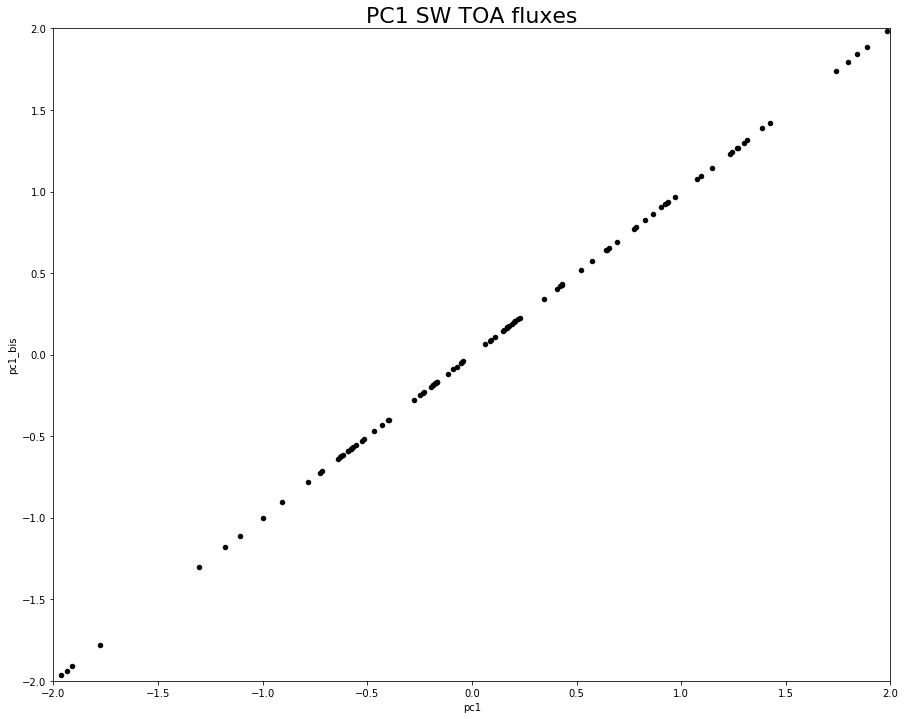

In [141]:
ax = plt.gca()
title = 'PC1 SW TOA fluxes'

df.plot(kind='scatter', x='pc1', y='pc1_bis', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
#plt.xlabel('Feedbacks (W.m^2)', fontsize=18)
#plt.ylabel('PC1 SW TOA fluxes', fontsize=18)
#plt.legend(['models', 'CERES dataset'])
plt.title(title, fontsize=22)
plt.ylim(-2.0,2.0)
plt.xlim(-2.0,2.0)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/Biases_VS_feedbacks.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

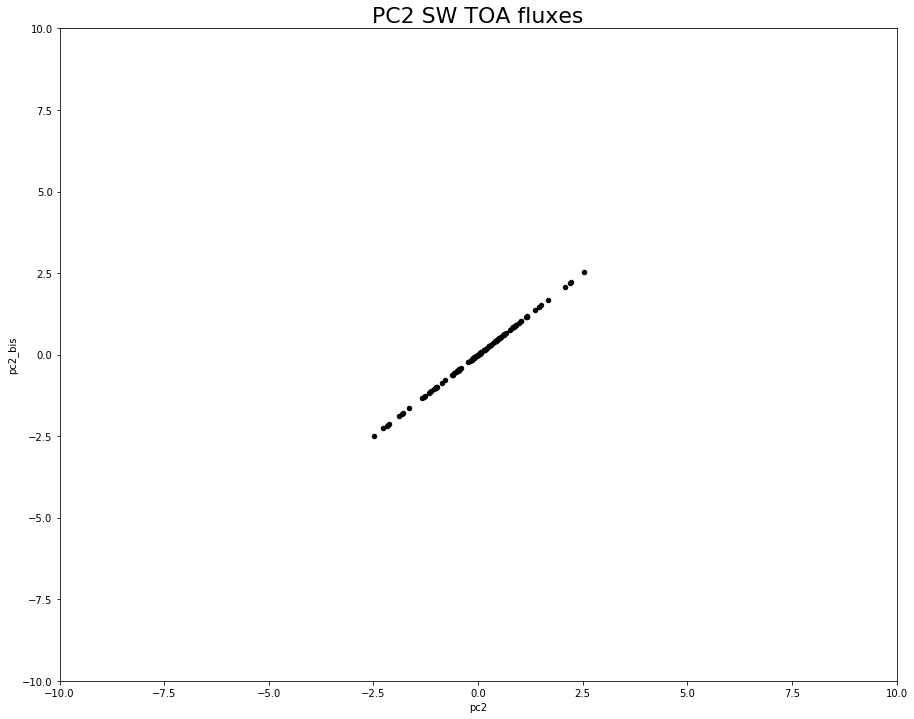

In [142]:
ax = plt.gca()
title = 'PC2 SW TOA fluxes'

df.plot(kind='scatter', x='pc2', y='pc2_bis', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
#plt.xlabel('Feedbacks (W.m^2)', fontsize=18)
#plt.ylabel('PC1 SW TOA fluxes', fontsize=18)
#plt.legend(['models', 'CERES dataset'])
plt.title(title, fontsize=22)
plt.ylim(-10,10)
plt.xlim(-10,10)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/Biases_VS_feedbacks.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

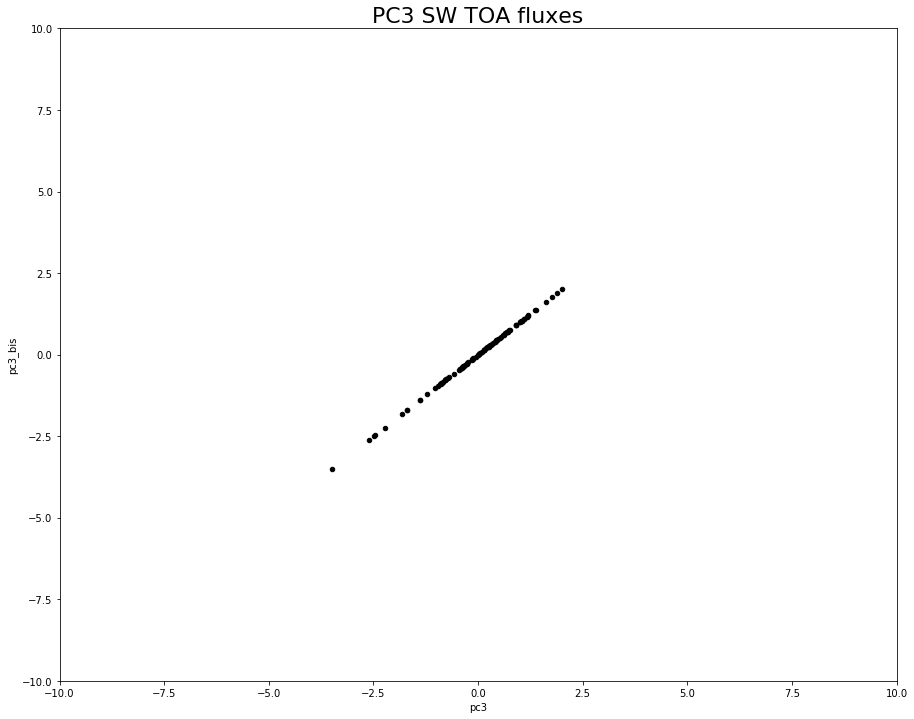

In [143]:
ax = plt.gca()
title = 'PC3 SW TOA fluxes'

df.plot(kind='scatter', x='pc3', y='pc3_bis', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
#plt.xlabel('Feedbacks (W.m^2)', fontsize=18)
#plt.ylabel('PC1 SW TOA fluxes', fontsize=18)
#plt.legend(['models', 'CERES dataset'])
plt.title(title, fontsize=22)
plt.ylim(-10,10)
plt.xlim(-10,10)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/Biases_VS_feedbacks.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [144]:
X_obs_bis = X_obs.expand_dims(dim={'dummy':range(0,102,1)})
X_obs_bis

<xarray.DataArray (dummy: 102, lat: 128, lon: 256)>
array([[[ 5.2181015,  5.2181015,  5.2181015, ...,  5.237549 ,
          5.2181015,  5.2181015],
        [ 1.2252731,  1.2252731,  1.2252731, ...,  1.2478867,
          1.2252731,  1.2252731],
        [ 4.9700813,  4.9700813,  4.9700813, ...,  5.088505 ,
          4.9700813,  4.9700813],
        ...,
        [11.630268 , 11.630268 , 11.630268 , ..., 11.095985 ,
         11.630268 , 11.630268 ],
        [11.547985 , 11.547985 , 11.547985 , ..., 11.503666 ,
         11.547985 , 11.547985 ],
        [11.785015 , 11.785015 , 11.785015 , ..., 11.783306 ,
         11.785015 , 11.785015 ]],

       [[ 5.2181015,  5.2181015,  5.2181015, ...,  5.237549 ,
          5.2181015,  5.2181015],
        [ 1.2252731,  1.2252731,  1.2252731, ...,  1.2478867,
          1.2252731,  1.2252731],
        [ 4.9700813,  4.9700813,  4.9700813, ...,  5.088505 ,
          4.9700813,  4.9700813],
        ...,
        [11.630268 , 11.630268 , 11.630268 , ..., 11.095985 ,
         11.630268 , 11.630268 ],
        [11.547985 , 11.547985 , 11.547985 , ..., 11.503666 ,
         11.547985 , 11.547985 ],
        [11.785015 , 11.785015 , 11.785015 , ..., 11.783306 ,
         11.785015 , 11.785015 ]],

       [[ 5.2181015,  5.2181015,  5.2181015, ...,  5.237549 ,
          5.2181015,  5.2181015],
        [ 1.2252731,  1.2252731,  1.2252731, ...,  1.2478867,
          1.2252731,  1.2252731],
        [ 4.9700813,  4.9700813,  4.9700813, ...,  5.088505 ,
          4.9700813,  4.9700813],
        ...,
        [11.630268 , 11.630268 , 11.630268 , ..., 11.095985 ,
         11.630268 , 11.630268 ],
        [11.547985 , 11.547985 , 11.547985 , ..., 11.503666 ,
         11.547985 , 11.547985 ],
        [11.785015 , 11.785015 , 11.785015 , ..., 11.783306 ,
         11.785015 , 11.785015 ]],

       ...,

       [[ 5.2181015,  5.2181015,  5.2181015, ...,  5.237549 ,
          5.2181015,  5.2181015],
        [ 1.2252731,  1.2252731,  1.2252731, ...,  1.2478867,
          1.2252731,  1.2252731],
        [ 4.9700813,  4.9700813,  4.9700813, ...,  5.088505 ,
          4.9700813,  4.9700813],
        ...,
        [11.630268 , 11.630268 , 11.630268 , ..., 11.095985 ,
         11.630268 , 11.630268 ],
        [11.547985 , 11.547985 , 11.547985 , ..., 11.503666 ,
         11.547985 , 11.547985 ],
        [11.785015 , 11.785015 , 11.785015 , ..., 11.783306 ,
         11.785015 , 11.785015 ]],

       [[ 5.2181015,  5.2181015,  5.2181015, ...,  5.237549 ,
          5.2181015,  5.2181015],
        [ 1.2252731,  1.2252731,  1.2252731, ...,  1.2478867,
          1.2252731,  1.2252731],
        [ 4.9700813,  4.9700813,  4.9700813, ...,  5.088505 ,
          4.9700813,  4.9700813],
        ...,
        [11.630268 , 11.630268 , 11.630268 , ..., 11.095985 ,
         11.630268 , 11.630268 ],
        [11.547985 , 11.547985 , 11.547985 , ..., 11.503666 ,
         11.547985 , 11.547985 ],
        [11.785015 , 11.785015 , 11.785015 , ..., 11.783306 ,
         11.785015 , 11.785015 ]],

       [[ 5.2181015,  5.2181015,  5.2181015, ...,  5.237549 ,
          5.2181015,  5.2181015],
        [ 1.2252731,  1.2252731,  1.2252731, ...,  1.2478867,
          1.2252731,  1.2252731],
        [ 4.9700813,  4.9700813,  4.9700813, ...,  5.088505 ,
          4.9700813,  4.9700813],
        ...,
        [11.630268 , 11.630268 , 11.630268 , ..., 11.095985 ,
         11.630268 , 11.630268 ],
        [11.547985 , 11.547985 , 11.547985 , ..., 11.503666 ,
         11.547985 , 11.547985 ],
        [11.785015 , 11.785015 , 11.785015 , ..., 11.783306 ,
         11.785015 , 11.785015 ]]], dtype=float32)
Coordinates:
  * dummy    (dummy) int64 0 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100 101
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'SWmean'

In [145]:
U_obs = np.dot(eofs_inv,X_obs_bis.transpose('lon','lat', 'dummy'))
#U_ens = U_ens.mean(dim=['lat','lon'])#.transpose()
U_obs

array([[[[ 0.45515057,  0.45515057,  0.45515057, ...,  0.45515057,
           0.45515057,  0.45515057],
         [ 0.7798894 ,  0.7798894 ,  0.7798894 , ...,  0.7798894 ,
           0.7798894 ,  0.7798894 ],
         [ 0.79788554,  0.79788554,  0.79788554, ...,  0.79788554,
           0.79788554,  0.79788554],
         ...,
         [ 0.72531414,  0.72531414,  0.72531414, ...,  0.72531414,
           0.72531414,  0.72531414],
         [ 0.58349687,  0.58349687,  0.58349687, ...,  0.58349687,
           0.58349687,  0.58349687],
         [ 0.5929557 ,  0.5929557 ,  0.5929557 , ...,  0.5929557 ,
           0.5929557 ,  0.5929557 ]],

        [[-3.1699946 , -3.1699946 , -3.1699946 , ..., -3.1699946 ,
          -3.1699946 , -3.1699946 ],
         [-4.0740547 , -4.0740547 , -4.0740547 , ..., -4.0740547 ,
          -4.0740547 , -4.0740547 ],
         [-4.413919  , -4.413919  , -4.413919  , ..., -4.413919  ,
          -4.413919  , -4.413919  ],
         ...,
         [-2.5971227 , -2.5971227 

In [146]:
U_obs = xr.DataArray(U_obs, dims=['lon','eofs','lon2', 'dummy'])
U_obs_avg = U_obs[0,:,0,0].transpose()
U_obs_avg

<xarray.DataArray (eofs: 5)>
array([ 0.45515057, -3.1699946 ,  0.5420869 ,  0.7715119 ,  1.3922025 ],
      dtype=float32)
Dimensions without coordinates: eofs

In [147]:
#Save the U_obs_avg 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_SW.npy', U_obs_avg)